### GRA WŁASNA - COLLECTGAME  
## Autorzy : Gabriela Bułat, Gabriela Chmielecka

### **1.Wstęp**
CollectGame jest to gra, w  której agent ma za zadanie zebrać jak największą ilość owoców omijając przy tym pojawiające się na planszy cukierki.

**Przestrzeń rozgrywki**

- Plansza 20x20
- Pozycja startowa gracza [10,10]
- Koniec gry następuje po wykonaniu 125 kroków

**Akcja**

Gracz, w każdym ruchu  ma do wyboru jedną z pięciu akcji:
- 0 - ruch w górę
- 1 - ruch w dółł
- 2 - ruch w lewo
- 3 - ruch w prawo
- 4 - pozostanie w miejscu

**Nagrody**

Przy każdym ruchu przemieszczającym gracza (akcja 0-3) gracz otrzymuje -0.05pkt.
Za zdobycie owoca gracz otrzymuje +10pkt.
Za zebranie cukierka gracz otrzymuje -10pkt.

**Przebieg gry**

Gracz poruszając się po planszy stara się zdobyć jak największą liczbę pojawiających się owoców. Owoce jak i cukierki, zostają na planszy do momentu ich 
zebrania lub do upłynięcia maksymalnego czasu (20 kolejnych kroków). Gracz stara się zminimalizować koszt ruchów, jednocześnie omijając pojawiające się na przestrzeni gry cukierki.

**Koniec gry**

Gra zostaje zakończona po upłynięciu czasu -wykonanie maksymalnej ilości akcji : 135.


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from typing import List, Tuple, Optional, Dict
import pygame
import os
import sys
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import time


aa

In [3]:
class CollectEnv(gym.Env):

    metadata = {"render_modes": ["human", "ansi"]}

    ACTIONS = ["up", "down", "left", "right", "none"]
    ACTION_MAP = {
        0: (-1, 0),   # up
        1: (1, 0),    # down
        2: (0, -1),   # left
        3: (0, 1),    # right
        4: (0, 0),    # none
    }

    def __init__(self, render_mode: Optional[str] = None):
        super().__init__()
        self.grid_size = (20, 20)
        self.cell_size = 20
        self.window_size = (self.grid_size[1] * self.cell_size, self.grid_size[0] * self.cell_size + 40)
        self.max_steps = 125
        self.start_pos = (10, 10)
        self.render_mode = render_mode

        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Dict({
            "position": spaces.Box(low=0, high=19, shape=(2,), dtype=np.int32),
            "step": spaces.Discrete(self.max_steps + 1),
        })
        self.assets = {}
        if render_mode == "human":
            pygame.init()
            self.window = pygame.display.set_mode(self.window_size)
            self.clock = pygame.time.Clock()
            self.load_assets()

        self.spawn_schedule: List[Tuple[int, str, Tuple[int, int]]] = [
            (0, "fruit", (2, 17)), (4, "candy", (3, 14)), (7, "fruit", (6, 6)),
            (17, "fruit", (10, 10)), (23, "candy", (15, 2)), (24, "fruit", (1, 1)),
            (27, "fruit", (11, 8)), (33, "fruit", (19, 19)), (36, "candy", (6, 0)),
            (37, "fruit", (2, 2)), (40, "candy", (3, 4)), (33, "fruit", (10, 6)),
            (45, "fruit", (14, 10)), (54, "fruit", (15, 2)), (59, "fruit", (19, 11)),
            (60, "candy", (8, 8)), (63, "candy", (7, 13)), (66, "fruit", (1, 6)),
            (75, "fruit", (4, 13)), (79, "candy", (9, 19)), (82, "fruit", (8, 15)),
            (83, "fruit", (10, 10)), (84, "candy", (17, 12)), (89, "fruit", (14, 11)),
            (94, "fruit", (8, 8)), (98, "fruit", (5, 13)), (99, "candy", (7, 14)),
            (105, "fruit", (10, 16)), (111, "candy", (8, 19)), (115, "fruit", (7, 19)),
        ]
        self.window = None
        self.clock = None
        self.reset()

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.agent_pos = list(self.start_pos)
        self.current_step = 0
        self.score = 0
        self.objects: Dict[Tuple[int, int], Tuple[str, int]] = {}
        self.game_over = False
        self.game_over_time = None
        return self._get_obs(), {}

    def step(self, action: int):
        assert self.action_space.contains(action), f"Invalid action: {action}"

        # Spawn new objects
        for spawn_time, obj_type, pos in self.spawn_schedule:
            if spawn_time == self.current_step:
                self.objects[pos] = (obj_type, self.current_step)

                # Remove expired objects (after 30 steps)
        expired_positions = [
            pos for pos, (_, spawn_step) in self.objects.items()
            if self.current_step - spawn_step >= 30
        ]
        for pos in expired_positions:
            del self.objects[pos]

        # Move agent
        delta = self.ACTION_MAP[action]
        new_row = min(max(self.agent_pos[0] + delta[0], 0), self.grid_size[0] - 1)
        new_col = min(max(self.agent_pos[1] + delta[1], 0), self.grid_size[1] - 1)
        self.agent_pos = [new_row, new_col]

        # Check for item pickup
        reward = 0
        pos_tuple = tuple(self.agent_pos)
        if pos_tuple in self.objects:
            obj_type, _ = self.objects[pos_tuple]
            if obj_type == "fruit":
                reward += 10
            elif obj_type == "candy":
                reward -= 10
            del self.objects[pos_tuple]

        # Action penalty
        if action in [0, 1, 2, 3]:  # up/down/left/right
            reward -= 0.05

        self.score += reward
        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        self.game_over = terminated

        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        pos = np.array(self.agent_pos, dtype=np.int32)

        # Znajdź najbliższy cel
        min_dist = float("inf")
        target_delta = (0, 0)
        target_type = 0  # 0 = brak, 1 = fruit, -1 = candy

        for (obj_x, obj_y), (obj_type, _) in self.objects.items():
            dx = obj_x - self.agent_pos[0]
            dy = obj_y - self.agent_pos[1]
            dist = abs(dx) + abs(dy)
            if dist < min_dist:
                min_dist = dist
                target_delta = (dx, dy)
                target_type = 1 if obj_type == "fruit" else -1

        return {
            "position": pos,
            "step": self.current_step,
            "target_delta": np.array(target_delta, dtype=np.int32),
            "target_type": target_type,
        }

    def load_assets(self):
        self.assets["agent"] = pygame.image.load(os.path.join("pictures", "girl.png"))
        self.assets["fruit"] = pygame.image.load(os.path.join("pictures", "apple.png"))
        self.assets["candy"] = pygame.image.load(os.path.join("pictures", "lollipop.png"))

        # Scale them to fit cell size
        for key in self.assets:
            self.assets[key] = pygame.transform.scale(self.assets[key], (self.cell_size, self.cell_size))



    def render(self):
        if self.render_mode != "human":
            return super().render()

        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode(self.window_size)
            pygame.display.set_caption("CollectEnv GUI")
            self.clock = pygame.time.Clock()
            self.font = pygame.font.SysFont("Arial", 20)

        self.window.fill((255, 255, 255))  # tło

        # punkty
        score_text = self.font.render(f"Punkty: {self.score:.1f}", True, (0, 0, 0))
        self.window.blit(score_text, (10, 10))

        offset_y = 40

        # Siatka
        for x in range(0, self.window_size[0], self.cell_size):
            pygame.draw.line(self.window, (200, 200, 200), (x, offset_y), (x, self.window_size[1]))
        for y in range(offset_y, self.window_size[1], self.cell_size):
            pygame.draw.line(self.window, (200, 200, 200), (0, y), (self.window_size[0], y))

        # Obiekty 
        for (x, y), item in self.objects.items():
            obj_type, _ = item
            sprite = self.assets["fruit"] if obj_type == "fruit" else self.assets["candy"]
            self.window.blit(sprite, (y * self.cell_size, x * self.cell_size + offset_y))

        # Agent 
        ax, ay = self.agent_pos
        self.window.blit(self.assets["agent"], (ay * self.cell_size, ax * self.cell_size + offset_y))

        pygame.display.flip()
        self.clock.tick(10)

    def close(self):
        if self.window is not None:
            pygame.quit()
            self.window = None


**Poniższy kod uruchamia grę w trybie graficznym - zachęcamy do podjęcia próby złapania jak najwięcej owocków !**

W celu przyjemniejszego grania klawisze ruchów zostały zmienione z cyfr na strzałki:

- strzałka górna - ruch w góre (zmiana z 0)
- strzałka dolna - ruch w dół (zmiana z 1)
- strzałka lewa - ruch w lewo (zmiana z 2)
- strzałka prawo - ruch w prawo (zmiana z 3)
- cyfra 4 - brak ruchu (niezmienione, gdyż rzadko użwane)

W części graficznej widzmy naszą przestrzeń gry, podzielona na siatkę w celu łatwego określenia odległości od celi. Poruszamy się postacią dziewczynki zbierając pojawiające się zdrowe jabłka, omijając po drodze niezdrowe słodycze.

In [6]:
env = CollectEnv(render_mode="human")
obs, _ = env.reset()

running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            break
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                running = False
                break

            action = 4  # brak ruchu
            if event.key == pygame.K_UP:
                action = 0
            elif event.key == pygame.K_DOWN:
                action = 1
            elif event.key == pygame.K_LEFT:
                action = 2
            elif event.key == pygame.K_RIGHT:
                action = 3

            obs, reward, done, _, _ = env.step(action)
            env.render()
            
            if done:
                print(f"Koniec gry. Zdobyte punkty: {env.score:.2f}. Resetuję...")
                obs, _ = env.reset()

env.close()
pygame.quit()
sys.exit()

 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: 9.95
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: 9.95
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: 9.95
 Reward: -0.05
 Reward: 9.95
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: 9.95
 Reward: -0.05
 Reward: -0.05
 Reward: 9.95
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: 9.95
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 Reward: -0.05
 R

SystemExit: 

In [8]:
def extract_state(obs):
    """
    Przekształca obserwację środowiska do reprezentacji stanu dla algorytmu Q-learning/SARSA.
    Przycinamy różnicę pozycji celu do [-10, 10], aby ograniczyć przestrzeń stanów.

    Args:
        obs (dict): obserwacja ze środowiska zawierająca pozycję agenta, różnicę do celu i typ celu.

    Returns:
        tuple: skwantyzowany stan jako krotka (x, y, dx, dy, typ celu)
    """
    dx = np.clip(obs["target_delta"][0], -10, 10)
    dy = np.clip(obs["target_delta"][1], -10, 10)
    return (
        obs["position"][0],
        obs["position"][1],
        dx,
        dy,
        obs["target_type"]
    )

In [9]:
def epsilon_greedy_policy(Q, state, epsilon, n_actions):
    """
    Strategia eksploracyjna epsilon-greedy: z prawdopodobieństwem epsilon wybierz losową akcję,
    w przeciwnym razie wybierz akcję maksymalizującą wartość Q.

    Args:
        Q (dict): tablica Q.
        state (tuple): obecny stan.
        epsilon (float): współczynnik eksploracji.
        n_actions (int): liczba możliwych akcji.

    Returns:
        int: wybrana akcja.
    """
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

In [17]:
def train_q_learning(env, episodes=500, alpha=0.1, gamma=0.9, epsilon=0.1):
    """
    Trenuje agenta za pomocą algorytmu Q-learning w podanym środowisku.

    Args:
        env: środowisko (np. CollectEnv).
        episodes (int): liczba epizodów treningowych.
        alpha (float): współczynnik uczenia.
        gamma (float): współczynnik dyskontujący przyszłe nagrody.
        epsilon (float): prawdopodobieństwo eksploracji.

    Returns:
        Q: wytrenowana tablica Q.
        episode_rewards: lista sum nagród z każdego epizodu.
        episode_times: lista czasów trwania epizodów.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    episode_rewards = []
    episode_times = []

    for ep in range(episodes):
        obs, _ = env.reset()
        state = extract_state(obs)
        total_reward = 0
        start_time = time.time()
        done = False

        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)
            next_obs, reward, done, _, _ = env.step(action)
            next_state = extract_state(next_obs)

            # Q-learning update rule
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][best_next_action]
            Q[state][action] += alpha * (td_target - Q[state][action])

            state = next_state
            total_reward += reward

        episode_rewards.append(total_reward)
        episode_times.append(time.time() - start_time)

        if (ep + 1) % 100 == 0:
            print(f"Q-Learning - Episode {ep + 1}, reward: {total_reward:.2f}")

    return Q, episode_rewards, episode_times


In [11]:

def train_sarsa(env, episodes=500, alpha=0.1, gamma=0.9, epsilon=0.1):
    """
    Trenuje agenta za pomocą algorytmu SARSA.

    Args:
        env: środowisko.
        episodes (int): liczba epizodów.
        alpha (float): współczynnik uczenia.
        gamma (float): współczynnik dyskontujący przyszłe nagrody.
        epsilon (float): prawdopodobieństwo eksploracji.

    Returns:
        Q: wytrenowana tablica Q.
        episode_rewards: lista sum nagród.
        episode_times: lista czasów trwania epizodów.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    episode_rewards = []
    episode_times = []

    for ep in range(episodes):
        obs, _ = env.reset()
        state = extract_state(obs)
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)

        total_reward = 0
        start_time = time.time()
        done = False

        while not done:
            next_obs, reward, done, _, _ = env.step(action)
            next_state = extract_state(next_obs)
            next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space.n)

            # SARSA update rule
            td_target = reward + gamma * Q[next_state][next_action]
            Q[state][action] += alpha * (td_target - Q[state][action])

            state = next_state
            action = next_action
            total_reward += reward

        episode_rewards.append(total_reward)
        episode_times.append(time.time() - start_time)

        if (ep + 1) % 100 == 0:
            print(f"SARSA - Episode {ep + 1}, reward: {total_reward:.2f}")

    return Q, episode_rewards, episode_times

In [12]:
def plot_training(rewards, times, method_name):
    """
    Generuje i wyświetla wykresy postępu treningu: nagroda i czas trwania epizodu.

    Args:
        rewards (list): nagrody z epizodów.
        times (list): czasy epizodów.
        method_name (str): nazwa metody (np. 'Q-Learning').
    """
    episodes = list(range(1, len(rewards) + 1))

    plt.figure(figsize=(14, 5))

    # Reward vs Episode
    plt.subplot(1, 2, 1)
    plt.plot(episodes, rewards, label="Reward", color="blue")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"{method_name}: Reward vs Episode")
    plt.grid(True)

    # Time vs Episode
    plt.subplot(1, 2, 2)
    plt.plot(episodes, times, label="Time", color="green")
    plt.xlabel("Episode")
    plt.ylabel("Time (seconds)")
    plt.title(f"{method_name}: Time vs Episode")
    plt.grid(True)

    plt.tight_layout()
    plt.show() 

In [13]:
env = CollectEnv(render_mode=None)


Q-Learning - Episode 100, reward: 37.60
Q-Learning - Episode 200, reward: 47.50
Q-Learning - Episode 300, reward: 46.50
Q-Learning - Episode 400, reward: 46.45
Q-Learning - Episode 500, reward: 46.25
Q-Learning - Episode 600, reward: 46.15
Q-Learning - Episode 700, reward: 45.65
Q-Learning - Episode 800, reward: 45.40
Q-Learning - Episode 900, reward: 45.15
Q-Learning - Episode 1000, reward: 45.35
Q-Learning - Episode 1100, reward: 44.35
Q-Learning - Episode 1200, reward: 44.50
Q-Learning - Episode 1300, reward: 44.75
Q-Learning - Episode 1400, reward: 44.95
Q-Learning - Episode 1500, reward: 44.65
Q-Learning - Episode 1600, reward: 44.55
Q-Learning - Episode 1700, reward: 45.25
Q-Learning - Episode 1800, reward: 44.35
Q-Learning - Episode 1900, reward: 44.60
Q-Learning - Episode 2000, reward: 45.10
Q-Learning - Episode 2100, reward: 46.80
Q-Learning - Episode 2200, reward: 45.20
Q-Learning - Episode 2300, reward: 44.75
Q-Learning - Episode 2400, reward: 45.85
Q-Learning - Episode 2500

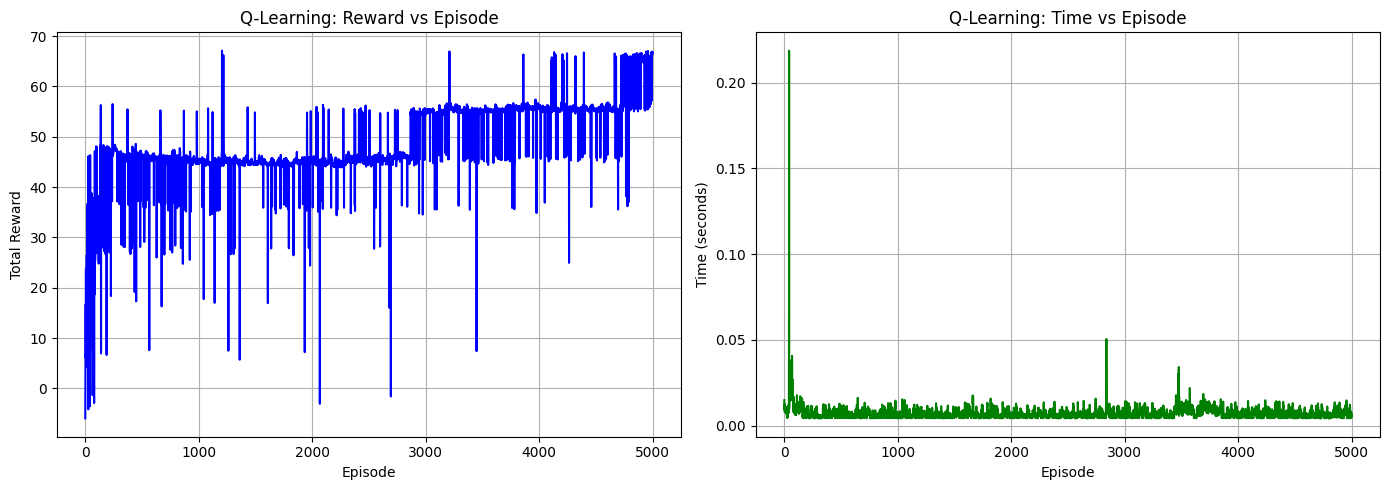

In [18]:
# Q-learning
q_table, q_rewards, q_times = train_q_learning(env, episodes=5000)
plot_training(q_rewards, q_times, method_name="Q-Learning")

SARSA - Episode 100, reward: 28.60
SARSA - Episode 200, reward: 46.60
SARSA - Episode 300, reward: 45.80
SARSA - Episode 400, reward: 45.95
SARSA - Episode 500, reward: 36.15
SARSA - Episode 600, reward: 45.65
SARSA - Episode 700, reward: 44.45
SARSA - Episode 800, reward: 68.15
SARSA - Episode 900, reward: 56.10
SARSA - Episode 1000, reward: 56.65
SARSA - Episode 1100, reward: 56.90
SARSA - Episode 1200, reward: 66.70
SARSA - Episode 1300, reward: 65.80
SARSA - Episode 1400, reward: 56.45
SARSA - Episode 1500, reward: 65.75
SARSA - Episode 1600, reward: 66.00
SARSA - Episode 1700, reward: 65.15
SARSA - Episode 1800, reward: 55.95
SARSA - Episode 1900, reward: 66.30
SARSA - Episode 2000, reward: 66.15
SARSA - Episode 2100, reward: 65.35
SARSA - Episode 2200, reward: 55.80
SARSA - Episode 2300, reward: 55.50
SARSA - Episode 2400, reward: 56.05
SARSA - Episode 2500, reward: 55.50
SARSA - Episode 2600, reward: 64.85
SARSA - Episode 2700, reward: 55.40
SARSA - Episode 2800, reward: 55.20
S

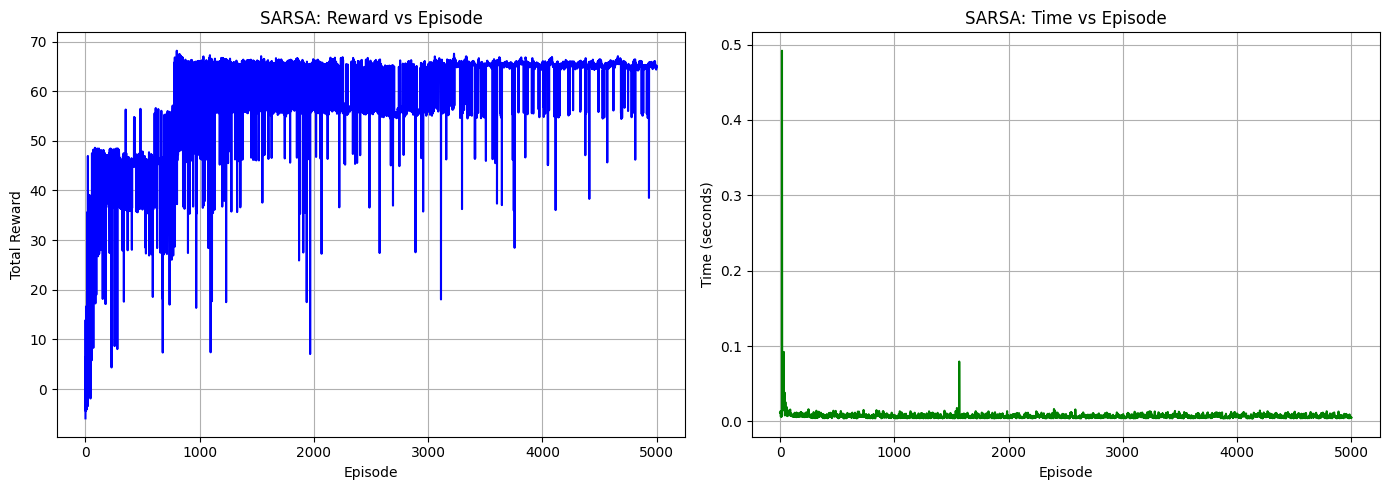

In [15]:
#SARSA 
sarsa_table, sarsa_rewards, sarsa_times = train_sarsa(env, episodes=5000)
plot_training(sarsa_rewards, sarsa_times, method_name="SARSA")

### *Wnioski*

